# Computer Vision Tutorial

This tutorial is for getting the hang of computer vision algorithms, primarily within OpenCV, for a wide variety of use cases. Shoutout to the GOAT, Ralph.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

OpenCV version: 4.10.0
Numpy version: 2.1.3
Matplotlib version: 3.9.2


In [2]:
# helper functions, feel free to ignore these

def show_image(image, map="gray"):
    plt.axis("off")
    plt.imshow(image, cmap=map)
    plt.show()

## Thresholding


For this section, we're going to use an FTC game piece as our object.

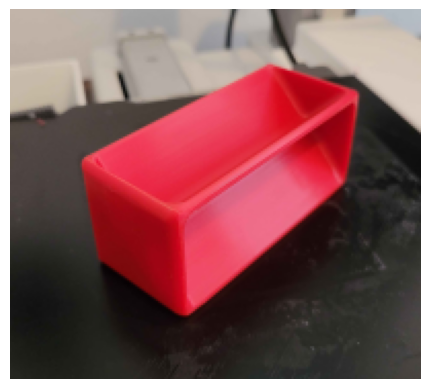

In [3]:
# Load the image
image = cv2.imread("images/ftc_piece.png")

# OpenCV loads images in BGR format, so we need to convert it to RGB to display it properly
image_to_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image
show_image(image_to_display)

One important part of vision is being able to segment images. One way to segment images is to threshold it.

Thresholding works by taking values higher, lower, or in between certain "thresholds" in an image. You can represent images as a 2D matrix:

![Image In the Form of a 2D Matrix](notebook_imgs/image.png)

...where each square represents one pixel. Of course, this is a simplified representation of a black and white image. In black and white images, each pixel ranges from 0-255, signifying the intensity or brightness. As you can figure, a value of 0 represents black, while a value of 255 represents white.

However, if you were to draw an RGB image, it would look more like a 3D matrix:

![RGB image](notebook_imgs/rgb%20image.png)

...where each of the 3 sections (rows*columns) represents R, G, or B to create color.

### Grayscale Thresholding

In this section, we're going to work with grayscale images.

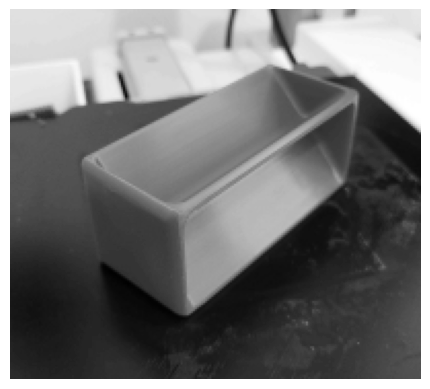

In [4]:
# Loads the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the image
show_image(gray_image)

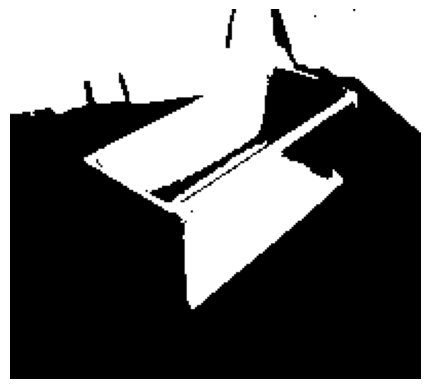

In [5]:
# Apply binary thresholding
# arguments are [image, threshold value, maxval, type of thresholding]
_, binary_thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY) # _ is just the threshold value that we ignore in this case

# Display the thresholded image
show_image(binary_thresh)

In the above threshold, the function returns a mask that contains the values above 100 in the image. These values are white, while pixel values under 100 are set to black.

It's important to note that there are different types of thresholding. The one we used is binary. Here are a couple examples and their use cases:

**cv2.THRESH_BINARY**: Pixels above the threshold are set to maxval, and below are set to 0.  
**cv2.THRESH_BINARY_INV**: Inverse of THRESH_BINARY.  
**cv2.THRESH_TRUNC**: Pixels above the threshold are set to the threshold value; others remain unchanged.  
**cv2.THRESH_TOZERO**: Pixels below the threshold are set to 0; others remain unchanged.  
**cv2.THRESH_TOZERO_INV**: Inverse of THRESH_TOZERO.

We also have Otsu's threshold, which determines the threshold value automatically, and adaptive thresholding, which tends to do better if an image contains varying lighting conditions by setting a threshold for a pixel based on a small region surrounding it.

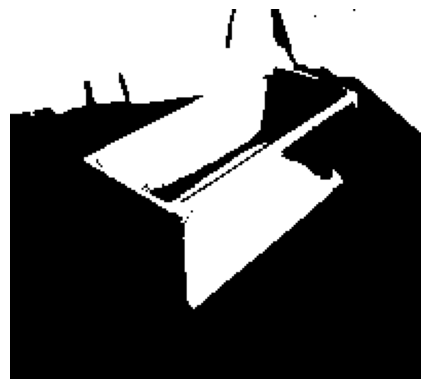

In [6]:
# Otsu's thresholding
_, otsu_thresholded = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

show_image(otsu_thresholded)

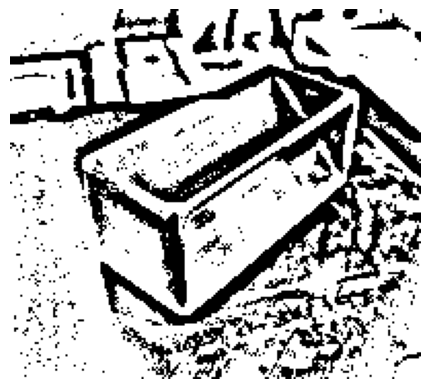

In [7]:
# Adaptive thresholding
# arguments are: [image, max value, adaptive method, threshold type, block size, constant]
adaptive_thresholded = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

show_image(adaptive_thresholded)

For adaptive thresholding, there are two threshold types:

**cv.ADAPTIVE_THRESH_MEAN_C**: The threshold value is the mean of the neighbourhood area minus the constant.  
**cv.ADAPTIVE_THRESH_GAUSSIAN_C**: The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant.  
- from OpenCV docs

There is no one size fits all. I encourage experimentation for your use cases to see what works best for you.

### Color thresholding

When dealing with colored images, we typically convert them to HSV first. For reference:

<img src="notebook_imgs/HSV.png" alt="hsv wheel" width="300"/>

This is the HSV color wheel.  
H - Hue  
S - Saturation  
V - Value

In OpenCV, H ranges from 0-179, S 0-255, and V 0-255. Here's a color map if you need it.

![hsv_map](notebook_imgs/hsv_map.png)

We use HSV because, at least in theory, thresholding should allow us to capture all instances of a specific color, regardless of the lighting. However, we'll see that in practice, this isn't the case.

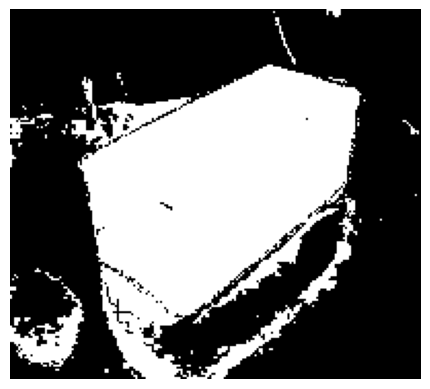

In [14]:
# [Hue, Saturation, Value]
lower_bound = np.array([10, 50, 0])
upper_bound = np.array([255, 255, 255])

# Convert the image to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create a mask
mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

# Show the mask
show_image(mask)

### Morphological Transformations

Often times, we'll need to perform transformations to get a better mask for our use case. Here are most of the transformations you'll often use:

**Erosion** - Removes pixels from boundaries of objects in image, useful for removing small white noise or separating connected objects.  
**Dilation** - Adds pixels to boundaries of objects, useful for closing small holes in an object.  
**Opening** - Erosion followed by dilation.  
**Closing** - Dilation followed by erosion.  
**Gradient** - The difference between dilation and erosion. Highlights edges of objects in the image.  
**Top Hat** - the difference between the input image and its opening. Highlights small, bright areas on a dark background.  
**Black Hat** - difference between the input image and its closing. Highlights small, dark areas on a bright background.

To do any of these transformations, you need a **kernel**. This is a shape that is going to go across the image and perform the transformation on a patch of pixels. You can create any shape by using a numpy array.

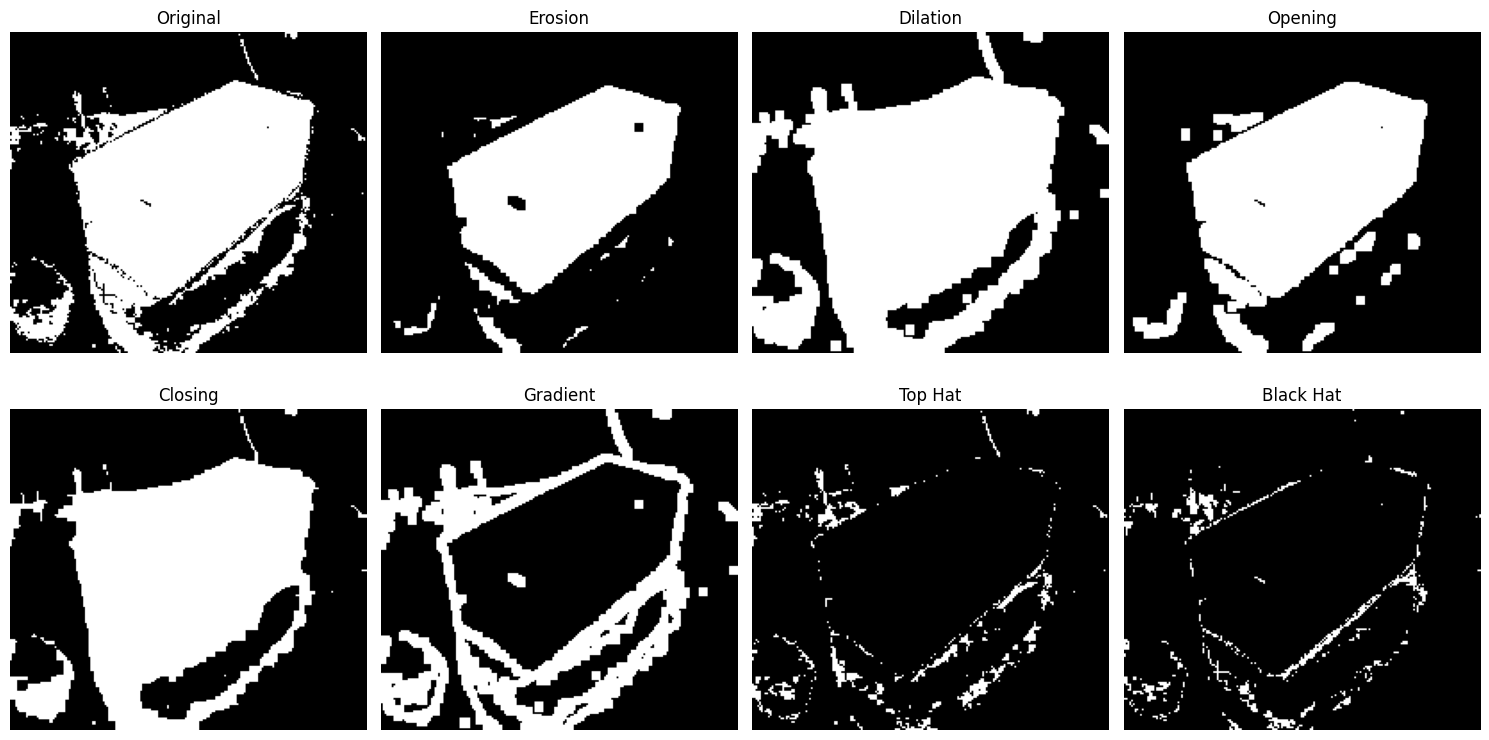

In [ ]:
# We'll use a rectangular kernel for this example
kernel = np.ones((5, 5), np.uint8)

# Apply morphological transformations
eroded = cv2.erode(mask, kernel, iterations=1) # iterations is the number of times the operation is applied
dilated = cv2.dilate(mask, kernel, iterations=1)
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(mask, cv2.MORPH_BLACKHAT, kernel)

# Display results
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing', 'Gradient', 'Top Hat', 'Black Hat']
images = [mask, eroded, dilated, opened, closed, gradient, tophat, blackhat]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Edge Detection